In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve, validation_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, naive_bayes,metrics
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from nltk.stem import LancasterStemmer
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split as ttsplit
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#Thực hiện load dữ liệu từ google drive
from google.colab import drive
drive.mount('/content/drive')
#Thực hiện load dữ liệu từ dataset file
df = pd.read_csv("/content/drive/My Drive/AI/mail_data.csv")
message_X = df.iloc[:,1] #Gán cột EmailText
labels_Y = df.iloc[:,0]  #Gán cột Label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


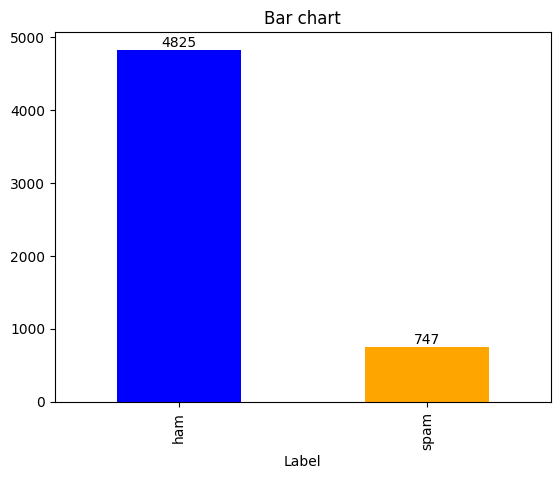

In [ ]:
import matplotlib.pyplot as plt

# Thống kê
count_Class = df["Label"].value_counts(sort=True)

# Vẽ bar chart và trả về Axes
ax = count_Class.plot(kind='bar', color=["blue","orange"])

# Duyệt qua từng thanh bar và thêm label
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        str(int(height)),                 # text là giá trị
        (p.get_x() + p.get_width()/2, height),  # vị trí: giữa thanh, trên đỉnh
        ha='center', va='bottom'
    )

plt.title('Bar chart')
plt.show()

In [13]:
#Khởi tạo biến
lstem = LancasterStemmer()
def mess(messages):
  message_x = []
  for me_x in messages:
    #Lọc dữ liệu ngoài trừ bảng chữ cái
    me_x=''.join(filter(lambda mes:(mes.isalpha() or mes==" ") ,me_x))
    #Chia nhỏ các body email thành các từ
    words = word_tokenize(me_x)
    #Nhóm các từ gốc lại
    message_x+=[' '.join([lstem.stem(word) for word in words])]
  return message_x

In [14]:
message_x = mess(message_X)
#Xử lí các túi từ, vector hóa, bỏ các từ dừng stopwords không cần thiết
tfvec=TfidfVectorizer(stop_words='english')
#vectorizing feature data
#Đưa dữ liệu về vector
x_new=tfvec.fit_transform(message_x).toarray()

In [15]:
#Chuyển đổi ham và spam thành giá trị 0 và 1
y_new = np.array(labels_Y.replace(to_replace=['ham', 'spam'], value=[0, 1]))

<ipython-input-15-24925be4a822>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_new = np.array(labels_Y.replace(to_replace=['ham', 'spam'], value=[0, 1]))


In [16]:
# Tách dataset thành dữ liệu training và testing
x_train , x_test , y_train , y_test = ttsplit(x_new,y_new,test_size=0.2,random_state=1)


In [33]:
#Sử dụng các model để phân loại
classifier = svm.SVC(kernel='linear')
# classifier=LogisticRegression()
# classifier=MultinomialNB()
# Use cross-validation to assess the model's performance on unseen data
#scores = cross_val_score(classifier, x_train, y_train, cv=5)
#print("Cross-validation accuracy: ", scores.mean(), "+/-", scores.std())
classifier.fit(x_train,y_train)

SVC(kernel='linear')

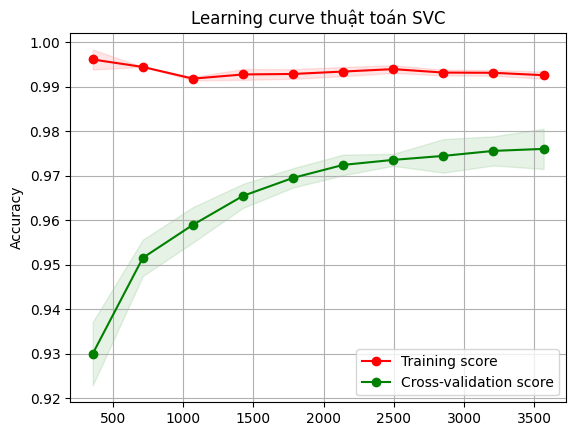

In [38]:
#Định nghĩa range cho training size
train_sizes = np.linspace(0.1, 1.0, 10)
# Sử dụng learning curve cho SVM model
train_sizes, train_scores, val_scores = learning_curve(classifier, x_train, y_train, train_sizes=train_sizes, cv=5)
# Tính giá trị trung bình và độ lệch cho training và validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
# Vẽ curve
plt.figure()
plt.title('Learning curve thuật toán SVC')
plt.ylabel("Accuracy")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [35]:
#Tính toán các giá trị test
Accuracy=accuracy_score(y_test, classifier.predict(x_test))
Precision=precision_score(y_test, classifier.predict(x_test))
Recall=recall_score(y_test, classifier.predict(x_test))
F1_Score=f1_score(y_test, classifier.predict(x_test))
print('Accuracy : {:.2f}%'.format(Accuracy*100))
print('Precision : {:.2f}%' .format(Precision*100))
print('Recall : {:.2f}%'.format(Recall*100))
print('F1-Score : {:.2f}%'.format(F1_Score*100))


Accuracy : 97.94%
Precision : 98.44%
Recall : 85.71%
F1-Score : 91.64%


In [36]:
#Tính toán confusion
m_confusion_test = metrics.confusion_matrix(y_test, classifier.predict(x_test))
pd.DataFrame(data = m_confusion_test, columns = ['Dự Đoán (Ham)', 'Dự đoán (Spam)'],
            index = ['Thực tế (Ham)', 'Thực tế (Spam)'])

,Dự Đoán (Ham),Dự đoán (Spam)
Thực tế (Ham),966,2
Thực tế (Spam),21,126


Confusion Matrix is : 
 [[966   2]
 [ 21 126]]


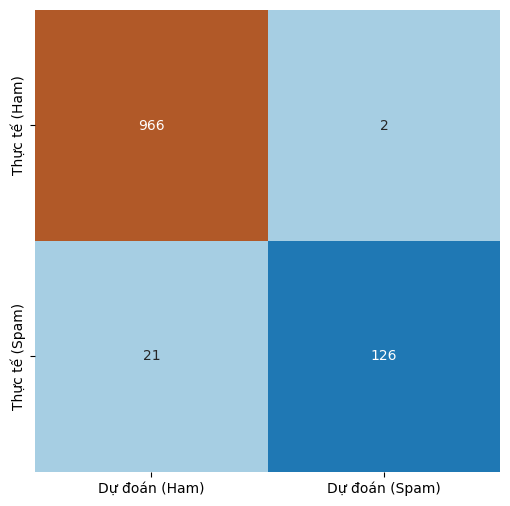

In [37]:
#Vẽ lên biểu đồ
import seaborn as sns
cmat = confusion_matrix(y_test, classifier.predict(x_test))
print('Confusion Matrix is : \n', cmat)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Dự đoán (Ham)', 'Dự đoán (Spam)'], yticklabels=['Thực tế (Ham)', 'Thực tế (Spam)']);